In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [75]:
def get_lat_name(ds):
    """Figure out what is the latitude coordinate for each dataset."""
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")
    
def get_lon_name(ds):
    """Figure out what is the latitude coordinate for each dataset."""
    for lon_name in ['lon', 'longitude']:
        if lon_name in ds.coords:
            return lon_name
    raise RuntimeError("Couldn't find a longitude coordinate")

def global_mean(ds,var):
    """Return global mean of var from dataset ds."""
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'bnds'}
    return (ds[var] * weight).mean(other_dims)

def lat_mean(ds,var,lati):
    """Return global mean of var from dataset ds."""
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat.where(lat>lati)))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'bnds'}
    return (ds[var] * weight).where(lat>lati).mean(other_dims)

def lat_gradient(ds,var):
    """Return latitudinal gradient (0<lat<30 - 60<lat) of var from dataset ds."""
    lat = ds[get_lat_name(ds)]
    weight_pole = np.cos(np.deg2rad(lat.where(lat>60)))
    weight_pole /= weight_pole.mean()
    weight_trop = np.cos(np.deg2rad(lat.where(lat>0).where(lat<30)))
    weight_trop /= weight_trop.mean()
    other_dims = set(ds.dims) - {'bnds'}
    return (ds[var] * weight_trop).where(lat>0).where(lat<30).mean(other_dims)-(ds[var] * weight_pole).where(lat>60).mean(other_dims)

def arctic_ts(ds,ds_s):
    """Return land (lat>70) surface temperature seasonality."""
    lat = ds[get_lat_name(ds)]
    other_dims = set(ds_s.sftlf.dims) - {get_lat_name(ds_s),get_lon_name(ds_s)}
    weights = np.cos(np.deg2rad(lat))
    weights.name = "weights"
    return ds.ts.where(ds_s.sftlf.mean(other_dims)>0).mean(get_lon_name(ds)).where(lat>70).weighted(weights).mean(get_lat_name(ds))-273

def arctic_ts_diff(ds,ds_s):
    """Return land (lat>70) surface temperature difference."""
    lat = ds[get_lat_name(ds)]
    other_dims = set(ds_s.sftlf.dims) - {get_lat_name(ds_s),get_lon_name(ds_s)}
    weights = np.cos(np.deg2rad(lat))
    weights.name = "weights"
    return ds.ts.where(ds_s.sftlf.mean(other_dims)>0).mean(get_lon_name(ds)).where(lat>70).weighted(weights).mean(get_lat_name(ds)).max()-ds.ts.where(ds_s.sftlf.mean(other_dims)>0).mean(get_lon_name(ds)).where(lat>70).weighted(weights).mean(get_lat_name(ds)).min()

In [78]:
cesm_sftlf = xr.open_dataset('./../data_eocene/CESM1.2_CAM5-deepmip_sens_1xCO2-sftlf-v1.0.mean.nc')
cesm_1x_clt = xr.open_dataset('./../data_eocene/CESM1.2_CAM5-deepmip_sens_1xCO2-clt-v1.0.mean.nc')
cesm_3x_clt = xr.open_dataset('./../data_eocene/CESM1.2_CAM5-deepmip_stand_3xCO2-clt-v1.0.mean.nc')
cesm_6x_clt = xr.open_dataset('./../data_eocene/CESM1.2_CAM5-deepmip_stand_6xCO2-clt-v1.0.mean.nc')
cesm_9x_clt = xr.open_dataset('./../data_eocene/CESM1.2_CAM5-deepmip_sens_9xCO2-clt-v1.0.mean.nc')
cesm_1x_ts = xr.open_dataset('./../data_eocene/CESM1.2_CAM5-deepmip_sens_1xCO2-ts-v1.0.mean.nc')
cesm_3x_ts = xr.open_dataset('./../data_eocene/CESM1.2_CAM5-deepmip_stand_3xCO2-ts-v1.0.mean.nc')
cesm_6x_ts = xr.open_dataset('./../data_eocene/CESM1.2_CAM5-deepmip_stand_6xCO2-ts-v1.0.mean.nc')
cesm_9x_ts = xr.open_dataset('./../data_eocene/CESM1.2_CAM5-deepmip_sens_9xCO2-ts-v1.0.mean.nc')
cesm_co2 = [1,3,6,9]
cesm_ts = [global_mean(cesm_1x_ts,'ts').values-273,global_mean(cesm_3x_ts,'ts').values-273,global_mean(cesm_6x_ts,'ts').values-273,global_mean(cesm_9x_ts,'ts').values-273]
cesm_clt = [global_mean(cesm_1x_clt,'clt').values,global_mean(cesm_3x_clt,'clt').values,global_mean(cesm_6x_clt,'clt').values,global_mean(cesm_9x_clt,'clt').values]
cesm_grad = [lat_gradient(cesm_1x_ts,'ts').values,lat_gradient(cesm_3x_ts,'ts').values,lat_gradient(cesm_6x_ts,'ts').values,lat_gradient(cesm_9x_ts,'ts').values]
cesm_ats_min = [arctic_ts(cesm_1x_ts,cesm_sftlf).min(),arctic_ts(cesm_3x_ts,cesm_sftlf).min(),arctic_ts(cesm_6x_ts,cesm_sftlf).min(),arctic_ts(cesm_9x_ts,cesm_sftlf).min()]
cesm_ats_max = [arctic_ts(cesm_1x_ts,cesm_sftlf).max(),arctic_ts(cesm_3x_ts,cesm_sftlf).max(),arctic_ts(cesm_6x_ts,cesm_sftlf).max(),arctic_ts(cesm_9x_ts,cesm_sftlf).max()]
cesm_pole_clt = [lat_mean(cesm_1x_clt,'clt',70),lat_mean(cesm_3x_clt,'clt',70),lat_mean(cesm_6x_clt,'clt',70),lat_mean(cesm_9x_clt,'clt',70)]

In [79]:
cosmos_sftlf = xr.open_dataset('./../data_eocene/COSMOS-landveg_r2413-deepmip_sens_all-sftlf.nc')
cosmos_1x_ts = xr.open_dataset('./../data_eocene/COSMOS-landveg_r2413-deepmip_sens_1xCO2-ts-v1.0.mean.nc')
cosmos_3x_ts = xr.open_dataset('./../data_eocene/COSMOS-landveg_r2413-deepmip_stand_3xCO2-ts-v1.0.mean.nc')
cosmos_4x_ts = xr.open_dataset('./../data_eocene/COSMOS-landveg_r2413-deepmip_sens_4xCO2-ts-v1.0.mean.nc')
cosmos_1x_clt = xr.open_dataset('./../data_eocene/COSMOS-landveg_r2413-deepmip_sens_1xCO2-clt-v1.0.mean.nc')
cosmos_3x_clt = xr.open_dataset('./../data_eocene/COSMOS-landveg_r2413-deepmip_stand_3xCO2-clt-v1.0.mean.nc')
cosmos_4x_clt = xr.open_dataset('./../data_eocene/COSMOS-landveg_r2413-deepmip_sens_4xCO2-clt-v1.0.mean.nc')
cosmos_co2 = [1,3,4]
cosmos_ts = [global_mean(cosmos_1x_ts,'ts').values-273,global_mean(cosmos_3x_ts,'ts').values-273,global_mean(cosmos_4x_ts,'ts').values-273]
cosmos_clt = [global_mean(cosmos_1x_clt,'clt').values,global_mean(cosmos_3x_clt,'clt').values,global_mean(cosmos_4x_clt,'clt').values]
cosmos_grad = [lat_gradient(cosmos_1x_ts,'ts').values,lat_gradient(cosmos_3x_ts,'ts').values,lat_gradient(cosmos_4x_ts,'ts').values]
cosmos_ats_min = [arctic_ts(cosmos_1x_ts,cosmos_sftlf).min(),arctic_ts(cosmos_3x_ts,cosmos_sftlf).min(),arctic_ts(cosmos_4x_ts,cosmos_sftlf).min()]
cosmos_ats_max = [arctic_ts(cosmos_1x_ts,cosmos_sftlf).max(),arctic_ts(cosmos_3x_ts,cosmos_sftlf).max(),arctic_ts(cosmos_4x_ts,cosmos_sftlf).max()]
cosmos_pole_clt = [lat_mean(cosmos_1x_clt,'clt',70),lat_mean(cosmos_3x_clt,'clt',70),lat_mean(cosmos_4x_clt,'clt',70)]

In [80]:
gfdl_sftlf = xr.open_dataset('./../data_eocene/GFDL_CM2.1-deepmip_sens_1xCO2-sftlf-v1.0.nc')
gfdl_1x_ts = xr.open_dataset('./../data_eocene/GFDL_CM2.1-deepmip_sens_1xCO2-ts-v1.0.mean.nc')
gfdl_2x_ts = xr.open_dataset('./../data_eocene/GFDL_CM2.1-deepmip_sens_2xCO2-ts-v1.0.mean.nc')
gfdl_4x_ts = xr.open_dataset('./../data_eocene/GFDL_CM2.1-deepmip_sens_4xCO2-ts-v1.0.mean.nc')
gfdl_6x_ts = xr.open_dataset('./../data_eocene/GFDL_CM2.1-deepmip_stand_6xCO2-ts-v1.0.mean.nc')
gfdl_1x_clt = xr.open_dataset('./../data_eocene/GFDL_CM2.1-deepmip_sens_1xCO2-clt-v1.0.mean.nc')
gfdl_2x_clt = xr.open_dataset('./../data_eocene/GFDL_CM2.1-deepmip_sens_2xCO2-clt-v1.0.mean.nc')
gfdl_4x_clt = xr.open_dataset('./../data_eocene/GFDL_CM2.1-deepmip_sens_4xCO2-clt-v1.0.mean.nc')
gfdl_6x_clt = xr.open_dataset('./../data_eocene/GFDL_CM2.1-deepmip_stand_6xCO2-clt-v1.0.mean.nc')
gfdl_co2 = [1,2,4,6]
gfdl_ts = [global_mean(gfdl_1x_ts,'ts').values-273,global_mean(gfdl_2x_ts,'ts').values-273,global_mean(gfdl_4x_ts,'ts').values-273,global_mean(gfdl_6x_ts,'ts').values-273]
gfdl_clt = [global_mean(gfdl_1x_clt,'clt').values,global_mean(gfdl_2x_clt,'clt').values,global_mean(gfdl_4x_clt,'clt').values,global_mean(gfdl_6x_clt,'clt').values]
gfdl_grad = [lat_gradient(gfdl_1x_ts,'ts').values,lat_gradient(gfdl_2x_ts,'ts').values,lat_gradient(gfdl_4x_ts,'ts').values,lat_gradient(gfdl_6x_ts,'ts').values]
gfdl_ats_min = [arctic_ts(gfdl_1x_ts,gfdl_sftlf).min(),arctic_ts(gfdl_2x_ts,gfdl_sftlf).min(),arctic_ts(gfdl_4x_ts,gfdl_sftlf).min(),arctic_ts(gfdl_6x_ts,gfdl_sftlf).min()]
gfdl_ats_max = [arctic_ts(gfdl_1x_ts,gfdl_sftlf).max(),arctic_ts(gfdl_2x_ts,gfdl_sftlf).max(),arctic_ts(gfdl_4x_ts,gfdl_sftlf).max(),arctic_ts(gfdl_6x_ts,gfdl_sftlf).max()]
gfdl_pole_clt = [lat_mean(gfdl_1x_clt,'clt',70),lat_mean(gfdl_2x_clt,'clt',70),lat_mean(gfdl_4x_clt,'clt',70),lat_mean(gfdl_6x_clt,'clt',70)]

In [81]:
hadcm_sftlf = xr.open_dataset('./../data_eocene/HadCM3BL_M2.1aN-deepmip_sens_1xCO2-sftlf-v1.0.nc')
hadcm_1x_ts = xr.open_dataset('./../data_eocene/HadCM3BL_M2.1aN-deepmip_sens_1xCO2-ts-v1.0.mean.nc',decode_times=False)
hadcm_2x_ts = xr.open_dataset('./../data_eocene/HadCM3BL_M2.1aN-deepmip_sens_2xCO2-ts-v1.0.mean.nc',decode_times=False)
hadcm_3x_ts = xr.open_dataset('./../data_eocene/HadCM3BL_M2.1aN-deepmip_stand_3xCO2-ts-v1.0.mean.nc',decode_times=False)
hadcm_1x_clt = xr.open_dataset('./../data_eocene/HadCM3BL_M2.1aN-deepmip_sens_1xCO2-clt-v1.0.mean.nc',decode_times=False)
hadcm_2x_clt = xr.open_dataset('./../data_eocene/HadCM3BL_M2.1aN-deepmip_sens_2xCO2-clt-v1.0.mean.nc',decode_times=False)
hadcm_3x_clt = xr.open_dataset('./../data_eocene/HadCM3BL_M2.1aN-deepmip_stand_3xCO2-clt-v1.0.mean.nc',decode_times=False)
hadcm_co2 = [1,2,3]
hadcm_ts = [global_mean(hadcm_1x_ts,'ts').values-273,global_mean(hadcm_2x_ts,'ts').values-273,global_mean(hadcm_3x_ts,'ts').values-273]
hadcm_clt = [global_mean(hadcm_1x_clt,'clt').values,global_mean(hadcm_2x_clt,'clt').values,global_mean(hadcm_3x_clt,'clt').values]
hadcm_grad = [lat_gradient(hadcm_1x_ts,'ts').values,lat_gradient(hadcm_2x_ts,'ts').values,lat_gradient(hadcm_3x_ts,'ts').values]
hadcm_ats_min = [arctic_ts(hadcm_1x_ts,hadcm_sftlf).min(),arctic_ts(hadcm_2x_ts,hadcm_sftlf).min(),arctic_ts(hadcm_3x_ts,hadcm_sftlf).min()]
hadcm_ats_max = [arctic_ts(hadcm_1x_ts,hadcm_sftlf).max(),arctic_ts(hadcm_2x_ts,hadcm_sftlf).max(),arctic_ts(hadcm_3x_ts,hadcm_sftlf).max()]
hadcm_pole_clt = [lat_mean(hadcm_1x_clt,'clt',70),lat_mean(hadcm_2x_clt,'clt',70),lat_mean(hadcm_3x_clt,'clt',70)]

In [82]:
ipsl_sftlf_pi = xr.open_dataset('./../data_eocene/IPSLCM5A2-piControl-sftlf-v1.0.nc')
ipsl_1x_ts = xr.open_dataset('./../data_eocene/IPSLCM5A2-piControl-ts-v1.0.mean.nc')
ipsl_1x_clt = xr.open_dataset('./../data_eocene/IPSLCM5A2-piControl-clt-v1.0.mean.nc')
ipsl_sftlf = xr.open_dataset('./../data_eocene/IPSLCM5A2-deepmip_sens_1.5xCO2-sftlf-v1.0.nc')
ipsl_15x_ts = xr.open_dataset('./../data_eocene/IPSLCM5A2-deepmip_sens_1.5xCO2-ts-v1.0.mean.nc')
ipsl_15x_clt = xr.open_dataset('./../data_eocene/IPSLCM5A2-deepmip_sens_1.5xCO2-clt-v1.0.mean.nc')
ipsl_3x_ts = xr.open_dataset('./../data_eocene/IPSLCM5A2-deepmip_stand_3xCO2-ts-v1.0.mean.nc')
ipsl_3x_clt = xr.open_dataset('./../data_eocene/IPSLCM5A2-deepmip_stand_3xCO2-clt-v1.0.mean.nc')
ipsl_co2 = [1,1.5,3]
ipsl_ts = [global_mean(ipsl_1x_ts,'ts').values-273,global_mean(ipsl_15x_ts,'ts').values-273,global_mean(ipsl_3x_ts,'ts').values-273]
ipsl_clt = [global_mean(ipsl_1x_clt,'clt').values,global_mean(ipsl_15x_clt,'clt').values,global_mean(ipsl_3x_clt,'clt').values]
ipsl_grad = [lat_gradient(ipsl_1x_ts,'ts').values,lat_gradient(ipsl_15x_ts,'ts').values,lat_gradient(ipsl_3x_ts,'ts').values]
ipsl_ats_min = [arctic_ts(ipsl_1x_ts,ipsl_sftlf_pi).min(),arctic_ts(ipsl_15x_ts,ipsl_sftlf).min(),arctic_ts(ipsl_3x_ts,ipsl_sftlf).min()]
ipsl_ats_max = [arctic_ts(ipsl_1x_ts,ipsl_sftlf_pi).max(),arctic_ts(ipsl_15x_ts,ipsl_sftlf).max(),arctic_ts(ipsl_3x_ts,ipsl_sftlf).max()]
ipsl_pole_clt = [lat_mean(ipsl_1x_clt,'clt',70),lat_mean(ipsl_15x_clt,'clt',70),lat_mean(ipsl_3x_clt,'clt',70)]

In [83]:
miroc_sftlf = xr.open_dataset('./../data_eocene/MIROC4m-deepmip_sens_1xCO2-sftlf-v1.0.mean.nc',decode_times=False)
miroc_1x_ts = xr.open_dataset('./../data_eocene/MIROC4m-deepmip_sens_1xCO2-ts-v1.0.mean.nc',decode_times=False)
miroc_2x_ts = xr.open_dataset('./../data_eocene/MIROC4m-deepmip_sens_2xCO2-ts-v1.0.mean.nc',decode_times=False)
miroc_3x_ts = xr.open_dataset('./../data_eocene/MIROC4m-deepmip_stand_3xCO2-ts-v1.0.mean.nc',decode_times=False)
miroc_1x_clt = xr.open_dataset('./../data_eocene/MIROC4m-deepmip_sens_1xCO2-clt-v1.0.mean.nc',decode_times=False)
miroc_2x_clt = xr.open_dataset('./../data_eocene/MIROC4m-deepmip_sens_2xCO2-clt-v1.0.mean.nc',decode_times=False)
miroc_3x_clt = xr.open_dataset('./../data_eocene/MIROC4m-deepmip_stand_3xCO2-clt-v1.0.mean.nc',decode_times=False)
miroc_co2 = [1,2,3]
miroc_ts = [global_mean(miroc_1x_ts,'ts').values-273,global_mean(miroc_2x_ts,'ts').values-273,global_mean(miroc_3x_ts,'ts').values-273]
miroc_clt = [global_mean(miroc_1x_clt,'clt').values,global_mean(miroc_2x_clt,'clt').values,global_mean(miroc_3x_clt,'clt').values]
miroc_grad = [lat_gradient(miroc_1x_ts,'ts').values,lat_gradient(miroc_2x_ts,'ts').values,lat_gradient(miroc_3x_ts,'ts').values]
miroc_ats_min = [arctic_ts(miroc_1x_ts,miroc_sftlf).min(),arctic_ts(miroc_2x_ts,miroc_sftlf).min(),arctic_ts(miroc_3x_ts,miroc_sftlf).min()]
miroc_ats_max = [arctic_ts(miroc_1x_ts,miroc_sftlf).max(),arctic_ts(miroc_2x_ts,miroc_sftlf).max(),arctic_ts(miroc_3x_ts,miroc_sftlf).max()]
miroc_pole_clt = [lat_mean(miroc_1x_clt,'clt',70),lat_mean(miroc_2x_clt,'clt',70),lat_mean(miroc_3x_clt,'clt',70)]

In [84]:
noresm_sftlf_pi = xr.open_dataset('./../data_eocene/NorESM1_F-piControl-sftlf-v1.0.mean.nc')
noresm_sftlf = xr.open_dataset('./../data_eocene/NorESM1_F-deepmip_sens_2xCO2-sftlf-v1.0.mean.nc')
noresm_1x_ts = xr.open_dataset('./../data_eocene/NorESM1_F-piControl-ts-v1.0.mean.nc')
noresm_2x_ts = xr.open_dataset('./../data_eocene/NorESM1_F-deepmip_sens_2xCO2-ts-v1.0.mean.nc')
noresm_4x_ts = xr.open_dataset('./../data_eocene/NorESM1_F-deepmip_sens_4xCO2-ts-v1.0.mean.nc')
noresm_1x_clt = xr.open_dataset('./../data_eocene/NorESM1_F-piControl-clt-v1.0.mean.nc')
noresm_2x_clt = xr.open_dataset('./../data_eocene/NorESM1_F-deepmip_sens_2xCO2-clt-v1.0.mean.nc')
noresm_4x_clt = xr.open_dataset('./../data_eocene/NorESM1_F-deepmip_sens_4xCO2-clt-v1.0.mean.nc')
noresm_co2 = [1,2,4]
noresm_ts = [global_mean(noresm_1x_ts,'ts').values-273,global_mean(noresm_2x_ts,'ts').values-273,global_mean(noresm_4x_ts,'ts').values-273]
noresm_clt = [global_mean(noresm_1x_clt,'clt').values,global_mean(noresm_2x_clt,'clt').values,global_mean(noresm_4x_clt,'clt').values]
noresm_grad = [lat_gradient(noresm_1x_ts,'ts').values,lat_gradient(noresm_2x_ts,'ts').values,lat_gradient(noresm_4x_ts,'ts').values]
noresm_ats_min = [arctic_ts(noresm_1x_ts,noresm_sftlf_pi).min(),arctic_ts(noresm_2x_ts,noresm_sftlf).min(),arctic_ts(noresm_4x_ts,noresm_sftlf).min()]
noresm_ats_max = [arctic_ts(noresm_1x_ts,noresm_sftlf_pi).max(),arctic_ts(noresm_2x_ts,noresm_sftlf).max(),arctic_ts(noresm_4x_ts,noresm_sftlf).max()]
noresm_pole_clt = [lat_mean(noresm_1x_clt,'clt',70),lat_mean(noresm_2x_clt,'clt',70),lat_mean(noresm_4x_clt,'clt',70)]

1xCO2 for noresm and ipsl is with preindustrial bc's!

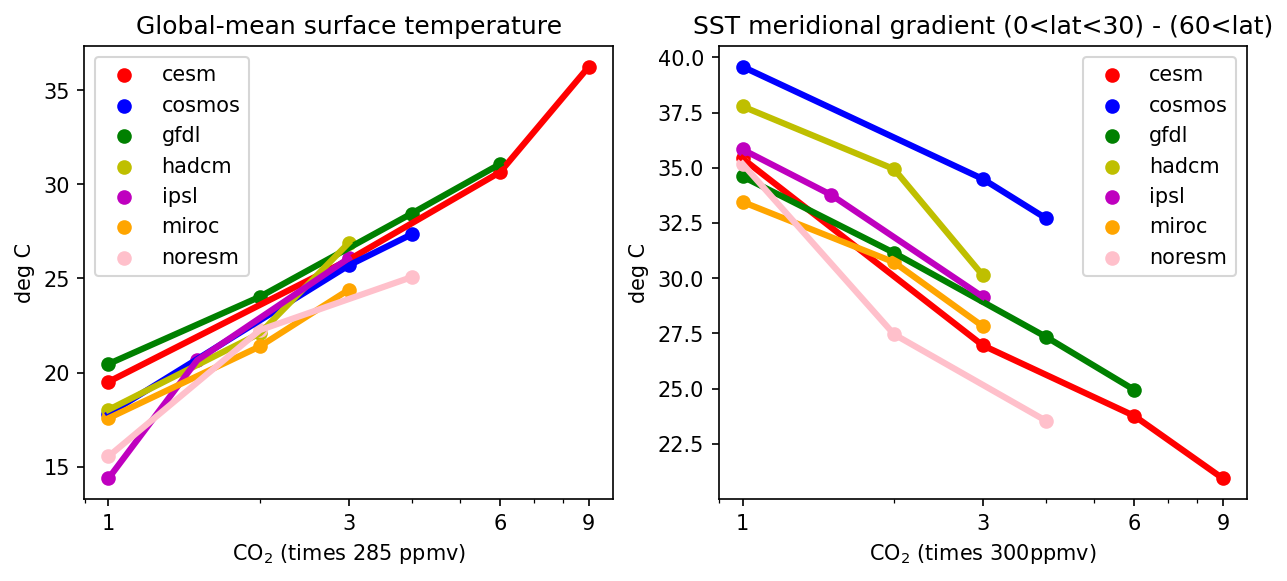

In [69]:
plt.figure(figsize=(10, 4),dpi=150)
plt.subplot(121)
plt.plot(cesm_co2,cesm_ts,c='r',lw=3)
plt.scatter(cesm_co2,cesm_ts,c='r',label='cesm')
plt.plot(cosmos_co2,cosmos_ts,c='b',lw=3)
plt.scatter(cosmos_co2,cosmos_ts,c='b',label='cosmos')
plt.plot(gfdl_co2,gfdl_ts,c='g',lw=3)
plt.scatter(gfdl_co2,gfdl_ts,c='g',label='gfdl')
plt.plot(hadcm_co2,hadcm_ts,c='y',lw=3)
plt.scatter(hadcm_co2,hadcm_ts,c='y',label='hadcm')
plt.plot(ipsl_co2,ipsl_ts,c='m',lw=3)
plt.scatter(ipsl_co2,ipsl_ts,c='m',label='ipsl')
plt.plot(miroc_co2,miroc_ts,c='orange',lw=3)
plt.scatter(miroc_co2,miroc_ts,c='orange',label='miroc')
plt.plot(noresm_co2,noresm_ts,c='pink',lw=3)
plt.scatter(noresm_co2,noresm_ts,c='pink',label='noresm')
plt.xscale('log')
plt.xticks(cesm_co2,['1','3','6','9'])
plt.ylabel('deg C')
plt.xlabel('CO$_2$ (times 285 ppmv)')
plt.title('Global-mean surface temperature')
plt.legend()
# plt.grid()
plt.subplot(122)
plt.plot(cesm_co2,cesm_grad,c='r',lw=3)
plt.scatter(cesm_co2,cesm_grad,c='r',label='cesm')
plt.plot(cosmos_co2,cosmos_grad,c='b',lw=3)
plt.scatter(cosmos_co2,cosmos_grad,c='b',label='cosmos')
plt.plot(gfdl_co2,gfdl_grad,c='g',lw=3)
plt.scatter(gfdl_co2,gfdl_grad,c='g',label='gfdl')
plt.plot(hadcm_co2,hadcm_grad,c='y',lw=3)
plt.scatter(hadcm_co2,hadcm_grad,c='y',label='hadcm')
plt.plot(ipsl_co2,ipsl_grad,c='m',lw=3)
plt.scatter(ipsl_co2,ipsl_grad,c='m',label='ipsl')
plt.plot(miroc_co2,miroc_grad,c='orange',lw=3)
plt.scatter(miroc_co2,miroc_grad,c='orange',label='miroc')
plt.plot(noresm_co2,noresm_grad,c='pink',lw=3)
plt.scatter(noresm_co2,noresm_grad,c='pink',label='noresm')
plt.xscale('log')
plt.xticks(cesm_co2,['1','3','6','9'])
plt.ylabel('deg C')
plt.xlabel('CO$_2$ (times 300ppmv)')
plt.title('SST meridional gradient (0<lat<30) - (60<lat)')
plt.legend()
# plt.grid()
plt.show()

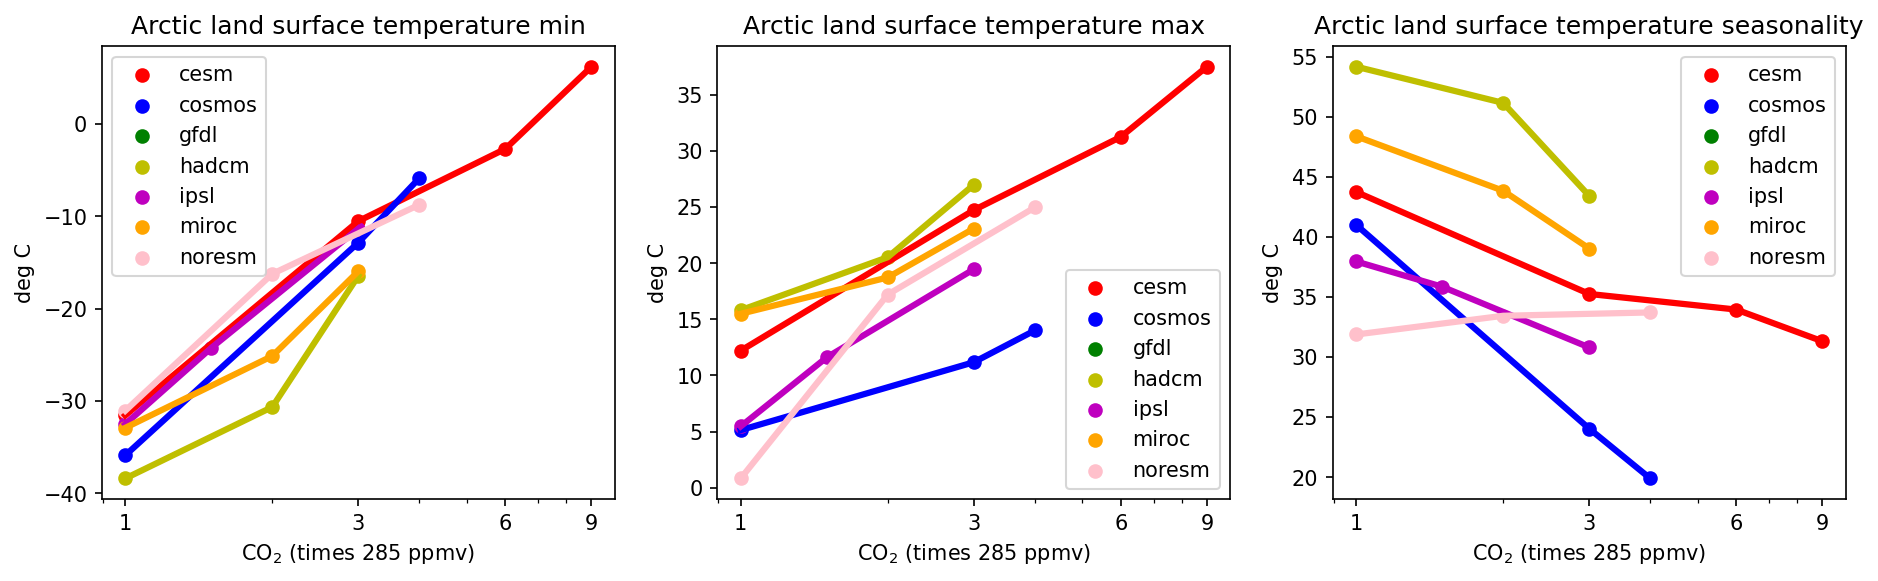

In [74]:
plt.figure(figsize=(15, 4),dpi=150)
plt.subplot(131)
plt.plot(cesm_co2,cesm_ats_min,c='r',lw=3)
plt.scatter(cesm_co2,cesm_ats_min,c='r',label='cesm')
plt.plot(cosmos_co2,cosmos_ats_min,c='b',lw=3)
plt.scatter(cosmos_co2,cosmos_ats_min,c='b',label='cosmos')
plt.plot(gfdl_co2,gfdl_ats_min,c='g',lw=3)
plt.scatter(gfdl_co2,gfdl_ats_min,c='g',label='gfdl')
plt.plot(hadcm_co2,hadcm_ats_min,c='y',lw=3)
plt.scatter(hadcm_co2,hadcm_ats_min,c='y',label='hadcm')
plt.plot(ipsl_co2,ipsl_ats_min,c='m',lw=3)
plt.scatter(ipsl_co2,ipsl_ats_min,c='m',label='ipsl')
plt.plot(miroc_co2,miroc_ats_min,c='orange',lw=3)
plt.scatter(miroc_co2,miroc_ats_min,c='orange',label='miroc')
plt.plot(noresm_co2,noresm_ats_min,c='pink',lw=3)
plt.scatter(noresm_co2,noresm_ats_min,c='pink',label='noresm')
plt.xscale('log')
plt.xticks(cesm_co2,['1','3','6','9'])
plt.ylabel('deg C')
plt.xlabel('CO$_2$ (times 285 ppmv)')
plt.title('Arctic land surface temperature min')
plt.legend()
plt.subplot(132)
plt.plot(cesm_co2,cesm_ats_max,c='r',lw=3)
plt.scatter(cesm_co2,cesm_ats_max,c='r',label='cesm')
plt.plot(cosmos_co2,cosmos_ats_max,c='b',lw=3)
plt.scatter(cosmos_co2,cosmos_ats_max,c='b',label='cosmos')
plt.plot(gfdl_co2,gfdl_ats_max,c='g',lw=3)
plt.scatter(gfdl_co2,gfdl_ats_max,c='g',label='gfdl')
plt.plot(hadcm_co2,hadcm_ats_max,c='y',lw=3)
plt.scatter(hadcm_co2,hadcm_ats_max,c='y',label='hadcm')
plt.plot(ipsl_co2,ipsl_ats_max,c='m',lw=3)
plt.scatter(ipsl_co2,ipsl_ats_max,c='m',label='ipsl')
plt.plot(miroc_co2,miroc_ats_max,c='orange',lw=3)
plt.scatter(miroc_co2,miroc_ats_max,c='orange',label='miroc')
plt.plot(noresm_co2,noresm_ats_max,c='pink',lw=3)
plt.scatter(noresm_co2,noresm_ats_max,c='pink',label='noresm')
plt.xscale('log')
plt.xticks(cesm_co2,['1','3','6','9'])
plt.ylabel('deg C')
plt.xlabel('CO$_2$ (times 285 ppmv)')
plt.title('Arctic land surface temperature max')
plt.legend()
plt.subplot(133)
plt.plot(cesm_co2,np.asarray(cesm_ats_max)-np.asarray(cesm_ats_min),c='r',lw=3)
plt.scatter(cesm_co2,np.asarray(cesm_ats_max)-np.asarray(cesm_ats_min),c='r',label='cesm')
plt.plot(cosmos_co2,np.asarray(cosmos_ats_max)-np.asarray(cosmos_ats_min),c='b',lw=3)
plt.scatter(cosmos_co2,np.asarray(cosmos_ats_max)-np.asarray(cosmos_ats_min),c='b',label='cosmos')
plt.plot(gfdl_co2,np.asarray(gfdl_ats_max)-np.asarray(gfdl_ats_min),c='g',lw=3)
plt.scatter(gfdl_co2,np.asarray(gfdl_ats_max)-np.asarray(gfdl_ats_min),c='g',label='gfdl')
plt.plot(hadcm_co2,np.asarray(hadcm_ats_max)-np.asarray(hadcm_ats_min),c='y',lw=3)
plt.scatter(hadcm_co2,np.asarray(hadcm_ats_max)-np.asarray(hadcm_ats_min),c='y',label='hadcm')
plt.plot(ipsl_co2,np.asarray(ipsl_ats_max)-np.asarray(ipsl_ats_min),c='m',lw=3)
plt.scatter(ipsl_co2,np.asarray(ipsl_ats_max)-np.asarray(ipsl_ats_min),c='m',label='ipsl')
plt.plot(miroc_co2,np.asarray(miroc_ats_max)-np.asarray(miroc_ats_min),c='orange',lw=3)
plt.scatter(miroc_co2,np.asarray(miroc_ats_max)-np.asarray(miroc_ats_min),c='orange',label='miroc')
plt.plot(noresm_co2,np.asarray(noresm_ats_max)-np.asarray(noresm_ats_min),c='pink',lw=3)
plt.scatter(noresm_co2,np.asarray(noresm_ats_max)-np.asarray(noresm_ats_min),c='pink',label='noresm')
plt.xscale('log')
plt.xticks(cesm_co2,['1','3','6','9'])
plt.ylabel('deg C')
plt.xlabel('CO$_2$ (times 285 ppmv)')
plt.title('Arctic land surface temperature seasonality')
plt.legend()
plt.show()

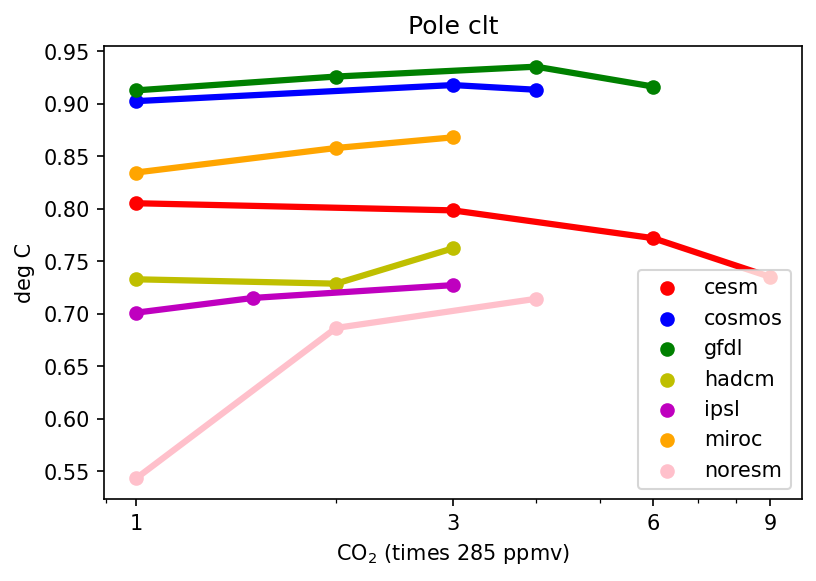

In [86]:
plt.figure(figsize=(6, 4),dpi=150)
plt.plot(cesm_co2,cesm_pole_clt,c='r',lw=3)
plt.scatter(cesm_co2,cesm_pole_clt,c='r',label='cesm')
plt.plot(cosmos_co2,cosmos_pole_clt,c='b',lw=3)
plt.scatter(cosmos_co2,cosmos_pole_clt,c='b',label='cosmos')
plt.plot(gfdl_co2,gfdl_pole_clt,c='g',lw=3)
plt.scatter(gfdl_co2,gfdl_pole_clt,c='g',label='gfdl')
plt.plot(hadcm_co2,hadcm_pole_clt,c='y',lw=3)
plt.scatter(hadcm_co2,hadcm_pole_clt,c='y',label='hadcm')
plt.plot(ipsl_co2,ipsl_pole_clt,c='m',lw=3)
plt.scatter(ipsl_co2,ipsl_pole_clt,c='m',label='ipsl')
plt.plot(miroc_co2,miroc_pole_clt,c='orange',lw=3)
plt.scatter(miroc_co2,miroc_pole_clt,c='orange',label='miroc')
plt.plot(noresm_co2,noresm_pole_clt,c='pink',lw=3)
plt.scatter(noresm_co2,noresm_pole_clt,c='pink',label='noresm')
plt.xscale('log')
plt.xticks(cesm_co2,['1','3','6','9'])
plt.ylabel('deg C')
plt.xlabel('CO$_2$ (times 285 ppmv)')
plt.title('Pole clt')
plt.legend()
plt.show()

Maybe the wrong metric! Check Arctic clt, or just low clouds, or just arctic land low clouds.